In [4]:
import pandas as pd # 基本ライブラリ
import numpy as np # 基本ライブラリ
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)


In [5]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample =pd.read_csv('sample_submit.csv',header =None)

In [6]:
X_submit =test.copy()

In [7]:
df.dtypes

gameId                 int64
blueFirstBlood         int64
blueKills              int64
blueDeaths             int64
blueAssists            int64
blueEliteMonsters      int64
blueDragons            int64
blueTotalGold          int64
blueTotalExperience    int64
blueWins               int64
dtype: object

# 開始10分間でのゲームのスコアを元に勝敗を予想する

In [8]:
df.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


In [9]:
X = df.drop('blueWins', axis=1)
X =X.drop('gameId',axis=1)

# 基礎分析

In [47]:
df[['blueFirstBlood','blueKills','blueDeaths','blueAssists','blueEliteMonsters','blueDragons','blueTotalGold','blueTotalExperience','blueWins']].corr() #相関係数

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
blueFirstBlood,1.000000,0.283559,-0.325833,0.241781,0.213862,0.155051,-0.111157,0.033651,0.226536
blueKills,0.283559,1.000000,-0.079929,0.710046,0.246184,0.196728,0.099387,0.309264,0.337541
blueDeaths,-0.325833,-0.079929,1.000000,-0.060368,-0.223138,-0.180798,0.060901,-0.051879,-0.237224
blueAssists,0.241781,0.710046,-0.060368,1.000000,0.213466,0.176668,0.108863,0.301567,0.311647
blueEliteMonsters,0.213862,0.246184,-0.223138,0.213466,1.000000,0.787022,0.149436,0.295139,0.272810
blueDragons,0.155051,0.196728,-0.180798,0.176668,0.787022,1.000000,0.185465,0.295516,0.251957
blueTotalGold,-0.111157,0.099387,0.060901,0.108863,0.149436,0.185465,1.000000,0.162229,0.040489
blueTotalExperience,0.033651,0.309264,-0.051879,0.301567,0.295139,0.295516,0.162229,1.000000,0.328167
blueWins,0.226536,0.337541,-0.237224,0.311647,0.272810,0.251957,0.040489,0.328167,1.000000


In [10]:
kill =df['blueKills']

(array([ 228.,  376., 1798., 1185., 1129., 1846.,  605.,  658.,   61.,
         114.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

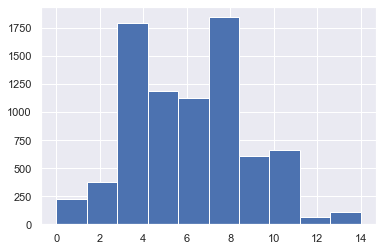

In [11]:
plt.hist(kill)

In [12]:
y =df['blueWins']

In [13]:
gold = df['blueTotalGold']

(array([ 614., 1142.,    0.,   20., 1068., 2065., 1506.,  698.,  536.,
         351.]),
 array([13475. , 14189.4, 14903.8, 15618.2, 16332.6, 17047. , 17761.4,
        18475.8, 19190.2, 19904.6, 20619. ]),
 <a list of 10 Patch objects>)

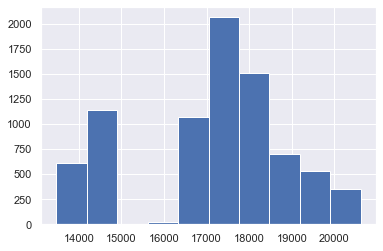

In [14]:
plt.hist(gold)

In [15]:
X.loc[X['blueTotalGold'] <= 14999,'groupA']='0'
X.loc[X['blueTotalGold'] > 15000,'groupA']='1'
#2グループにきれいに分かれているのでカテゴリー変数として使う

(array([  12., 3334.,    6.,  768., 1588., 1457.,  126.,    0.,  357.,
         352.]),
 array([16650. , 16995.1, 17340.2, 17685.3, 18030.4, 18375.5, 18720.6,
        19065.7, 19410.8, 19755.9, 20101. ]),
 <a list of 10 Patch objects>)

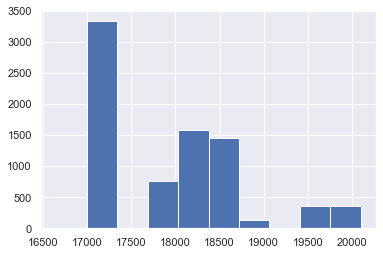

In [16]:
ex = df['blueTotalExperience']
plt.hist(ex)

In [17]:
X.loc[X['blueTotalExperience'] >19200, 'groupB'] = '0'
X.loc[X['blueTotalExperience'] <17500, 'groupB'] = '-1'
X.loc[(X['blueTotalExperience'] >=17500) & (X['blueTotalExperience'] <=19200) , 'groupB'] = '1'
# こちらもグループに分かれているのでカテゴリー変数として使う

In [18]:
X['groupA']=X['groupA'].astype('category')
X['groupB']=X['groupB'].astype('category')

In [19]:
X.dtypes

blueFirstBlood            int64
blueKills                 int64
blueDeaths                int64
blueAssists               int64
blueEliteMonsters         int64
blueDragons               int64
blueTotalGold             int64
blueTotalExperience       int64
groupA                 category
groupB                 category
dtype: object

In [20]:
X.head(20)

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,groupA,groupB
0,0,5,8,6,0,0,14536,17256,0,-1
1,1,10,1,5,0,0,14536,17863,0,1
2,0,3,10,2,0,0,17409,17256,1,-1
3,1,7,10,8,0,0,19558,18201,1,1
4,0,4,9,4,0,0,17409,17256,1,-1
5,0,5,10,8,0,0,17409,19730,1,0
6,0,5,4,6,1,1,20038,19730,1,0
7,1,8,5,13,1,0,18274,18491,1,1
8,0,5,6,6,1,0,14536,18986,0,1
9,1,7,4,9,1,1,18274,18021,1,1


In [21]:
X['bonus']=(X['blueFirstBlood']*20 )+(X['blueDragons']*10)+((X['blueEliteMonsters']*10))

In [22]:
X['bonus'] =X['bonus'].astype('int64')

In [23]:
# カテゴリー変数
categorical_features = {*sorted(['groupA'])}
categorical_features = {*sorted(['groupB'])}

In [24]:
X.head(30)

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,groupA,groupB,bonus
0,0,5,8,6,0,0,14536,17256,0,-1,0
1,1,10,1,5,0,0,14536,17863,0,1,20
2,0,3,10,2,0,0,17409,17256,1,-1,0
3,1,7,10,8,0,0,19558,18201,1,1,20
4,0,4,9,4,0,0,17409,17256,1,-1,0
5,0,5,10,8,0,0,17409,19730,1,0,0
6,0,5,4,6,1,1,20038,19730,1,0,20
7,1,8,5,13,1,0,18274,18491,1,1,30
8,0,5,6,6,1,0,14536,18986,0,1,10
9,1,7,4,9,1,1,18274,18021,1,1,40


# モデル作成

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2)

In [26]:
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
# 検証用
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,
                       free_raw_data=False)

In [27]:
params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 2,                 # 目的変数のクラス数
          'learning_rate': 0.01,          # 学習率（初期値0.1）
          'num_leaves': 30,               # 決定木の複雑度を調整（初期値31）
          'min_data_in_leaf': 1,          # データの最小数（初期値20）
         }

In [28]:

gbm = lgb.train(params,
                lgb_train,
                valid_sets=(lgb_train,lgb_eval),
                num_boost_round=10000,#学習サイクル
                early_stopping_rounds=200,#過学習を防ぐ
                verbose_eval=50)         #50サイクルごとの評価       

#左が訓練用データでの予測値ー正答値の誤差評価、右がモデル評価用データでの予測値ー正答値の誤差評価

Training until validation scores don't improve for 200 rounds
[50]	training's multi_logloss: 0.556544	valid_1's multi_logloss: 0.56238
[100]	training's multi_logloss: 0.493787	valid_1's multi_logloss: 0.50506
[150]	training's multi_logloss: 0.460721	valid_1's multi_logloss: 0.477351
[200]	training's multi_logloss: 0.441791	valid_1's multi_logloss: 0.463568
[250]	training's multi_logloss: 0.428392	valid_1's multi_logloss: 0.457223
[300]	training's multi_logloss: 0.418712	valid_1's multi_logloss: 0.454577
[350]	training's multi_logloss: 0.410026	valid_1's multi_logloss: 0.452926
[400]	training's multi_logloss: 0.402485	valid_1's multi_logloss: 0.45073
[450]	training's multi_logloss: 0.395657	valid_1's multi_logloss: 0.449923
[500]	training's multi_logloss: 0.389716	valid_1's multi_logloss: 0.450139
[550]	training's multi_logloss: 0.384015	valid_1's multi_logloss: 0.450249
[600]	training's multi_logloss: 0.378842	valid_1's multi_logloss: 0.449974
[650]	training's multi_logloss: 0.373947	v

In [32]:
# テストデータで予測
test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
test_pred_max = np.argmax(test_pred, axis=1)

accuracy = sum(y_test == test_pred_max) / len(y_test)
print('accuracy:', accuracy)


accuracy: 0.78375


# 提出用データ作成

In [166]:
X_test

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,groupA,groupB,bonus
6315,1,5,6,4,1,0,16544,18201,1,1,30
1457,0,4,6,1,0,0,17409,17256,1,-1,0
7778,1,7,2,6,1,0,13519,18021,0,1,30
5623,0,4,10,4,0,0,17409,17256,1,-1,0
739,0,6,5,5,1,1,14536,17256,0,-1,20
...,...,...,...,...,...,...,...,...,...,...,...
2641,1,11,5,9,1,1,13519,18491,0,1,40
7362,1,4,9,3,0,0,14536,17256,0,-1,20
1330,0,3,5,2,1,1,14536,17256,0,-1,20
2220,0,4,6,4,1,0,19558,18201,1,1,10


In [34]:
X_submit =X_submit.drop('gameId',axis=1)

In [35]:
X_submit.loc[X_submit['blueTotalGold'] <= 14999,'groupA']='0'
X_submit.loc[X_submit['blueTotalGold'] > 15000,'groupA']='1'

In [36]:
X_submit.loc[X_submit['blueTotalExperience'] >19200, 'groupB'] = '0'
X_submit.loc[X_submit['blueTotalExperience'] <17500, 'groupB'] = '-1'
X_submit.loc[(X_submit['blueTotalExperience'] >=17500) & (X['blueTotalExperience'] <=19200) , 'groupB'] = '1'

In [37]:
X_submit['groupA']=X_submit['groupA'].astype('category')
X_submit['groupB']=X_submit['groupB'].astype('category')

In [38]:
X_submit

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,groupA,groupB
0,0,7,6,6,0,0,16961,18201,1,1
1,0,6,6,6,2,1,18513,18021,1,1
2,1,6,4,3,0,0,13475,17256,0,-1
3,0,5,4,7,0,0,17409,17256,1,-1
4,0,10,8,9,0,0,18117,18472,1,1
...,...,...,...,...,...,...,...,...,...,...
1995,0,6,3,7,0,0,17409,17256,1,-1
1996,0,4,4,4,0,0,17409,17256,1,-1
1997,1,6,3,3,1,1,18513,18201,1,1
1998,1,10,9,9,1,1,18513,18201,1,1


In [39]:
X_submit['bonus']=(X_submit['blueFirstBlood']*20)+ (X_submit['blueEliteMonsters']*10)+(X_submit['blueDragons']*10)

In [40]:
X_submit['bonus'] =X_submit['bonus'].astype('int64')

In [41]:
X_submit

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,groupA,groupB,bonus
0,0,7,6,6,0,0,16961,18201,1,1,0
1,0,6,6,6,2,1,18513,18021,1,1,30
2,1,6,4,3,0,0,13475,17256,0,-1,20
3,0,5,4,7,0,0,17409,17256,1,-1,0
4,0,10,8,9,0,0,18117,18472,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,0,6,3,7,0,0,17409,17256,1,-1,0
1996,0,4,4,4,0,0,17409,17256,1,-1,0
1997,1,6,3,3,1,1,18513,18201,1,1,40
1998,1,10,9,9,1,1,18513,18201,1,1,40


In [43]:

submit = gbm.predict(X_submit)
submit_max = np.argmax(submit, axis=1)



In [45]:
submit_max

array([1, 1, 1, ..., 1, 1, 1])